In [2]:
##!pip install spacy pyLDAvis

In [3]:
!python -m spacy download pt_core_news_sm

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
2022-12-17 14:23:18.046936: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.0 MB 5.2 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import spacy
import nltk
import re
from nltk import word_tokenize
from nltk.util import ngrams
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
import warnings
warnings.filterwarnings('ignore')
nlp_pt = spacy.load('pt_core_news_sm')

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [5]:
# executar apenas uma vez
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [6]:
news = pd.read_csv('https://www.dropbox.com/s/rvwjw8miow6jswy/articles.csv?dl=1')

In [7]:
news.head()

,title,text,date,category,subcategory,link
0,"Lula diz que está 'lascado', mas que ainda tem...",Com a possibilidade de uma condenação impedir ...,2017-09-10,poder,NaN,http://www1.folha.uol.com.br/poder/2017/10/192...
1,"'Decidi ser escrava das mulheres que sofrem', ...","Para Oumou Sangaré, cantora e ativista malines...",2017-09-10,ilustrada,NaN,http://www1.folha.uol.com.br/ilustrada/2017/10...
2,Três reportagens da Folha ganham Prêmio Petrob...,Três reportagens da Folha foram vencedoras do ...,2017-09-10,poder,NaN,http://www1.folha.uol.com.br/poder/2017/10/192...
3,Filme 'Star Wars: Os Últimos Jedi' ganha trail...,A Disney divulgou na noite desta segunda-feira...,2017-09-10,ilustrada,NaN,http://www1.folha.uol.com.br/ilustrada/2017/10...
4,CBSS inicia acordos com fintechs e quer 30% do...,"O CBSS, banco da holding Elopar dos sócios Bra...",2017-09-10,mercado,NaN,http://www1.folha.uol.com.br/mercado/2017/10/1...


Filtro pela categoria "turismo"

In [8]:
turismo = news[news['category'] == 'turismo']

In [9]:
turismo.head()

,title,text,date,category,subcategory,link
381,Latam inaugura voo direto de 15 horas entre Ch...,Animem-se os que pretendem cruzar o Pacífico e...,2017-06-10,turismo,NaN,http://www1.folha.uol.com.br/turismo/2017/10/1...
414,Turismo de Las Vegas deve se recuperar em mese...,O massacre em Las Vegas afetará o turismo da c...,2017-06-10,turismo,NaN,http://www1.folha.uol.com.br/turismo/2017/10/1...
522,Brasileiro cria app para economizar no passeio...,"Com cerca de 50 mil visitantes por dia, Veneza...",2017-05-10,turismo,NaN,http://www1.folha.uol.com.br/turismo/2017/10/1...
602,AirBnB passa a fazer reserva de restaurantes,A plataforma de hospedagem Airbnb anunciou que...,2017-05-10,turismo,NaN,http://www1.folha.uol.com.br/turismo/2017/10/1...
609,Museus lembram quatro décadas de opressão sovi...,Nos países que viveram sob a órbita da União S...,2017-05-10,turismo,NaN,http://www1.folha.uol.com.br/turismo/2017/10/1...


In [10]:

def limpa_texto(texto):
  # remove \n e \r
  c = re.sub(r'\n', ' ', texto)
  c = re.sub(r'\r', ' ', c)
  
  # remove caracteres alfanumericos
  c = c.replace(':', '')
  c = c.replace('/', '')
  c = re.sub(r'R\$', '', c)
  c = re.sub(r'\W', ' ', c)
  # remove espaços adicionais
  c = re.sub(r'\s+', ' ', c)
  # remove espacos adicionais no inicio das frases
  c = re.sub(r'^\s+', '', c)
  # remove espacos adicionais no final das frases
  c = re.sub(r'\s+$', '', c)
 
  return c.lower()

In [11]:
from spacy.lang.pt import Portuguese
STOP_WORDS = spacy.lang.pt.stop_words.STOP_WORDS
STOP_WORDS.update('ao')

def remove_stop(texto):
  doc = nlp_pt(texto)
  return " ".join(x.text for x in doc if x.text not in STOP_WORDS)

In [12]:
def limpa_texto2(texto):
  doc = nlp_pt(texto)
  return " ".join(x.lemma_ for x in doc if x.text not in STOP_WORDS)

In [13]:
STOP_WORDS

{'a',
 'acerca',
 'ademais',
 'adeus',
 'agora',
 'ainda',
 'algo',
 'algumas',
 'alguns',
 'ali',
 'além',
 'ambas',
 'ambos',
 'antes',
 'ao',
 'aos',
 'apenas',
 'apoia',
 'apoio',
 'apontar',
 'após',
 'aquela',
 'aquelas',
 'aquele',
 'aqueles',
 'aqui',
 'aquilo',
 'as',
 'assim',
 'através',
 'atrás',
 'até',
 'aí',
 'baixo',
 'bastante',
 'bem',
 'boa',
 'bom',
 'breve',
 'cada',
 'caminho',
 'catorze',
 'cedo',
 'cento',
 'certamente',
 'certeza',
 'cima',
 'cinco',
 'coisa',
 'com',
 'como',
 'comprida',
 'comprido',
 'conhecida',
 'conhecido',
 'conselho',
 'contra',
 'contudo',
 'corrente',
 'cuja',
 'cujo',
 'custa',
 'cá',
 'da',
 'daquela',
 'daquele',
 'dar',
 'das',
 'de',
 'debaixo',
 'demais',
 'dentro',
 'depois',
 'des',
 'desde',
 'dessa',
 'desse',
 'desta',
 'deste',
 'deve',
 'devem',
 'deverá',
 'dez',
 'dezanove',
 'dezasseis',
 'dezassete',
 'dezoito',
 'diante',
 'direita',
 'disso',
 'diz',
 'dizem',
 'dizer',
 'do',
 'dois',
 'dos',
 'doze',
 'duas',
 'dá

Estatísticas básicas

1. número de palavras no titulo das noticias

In [14]:
turismo['title_n_words'] = turismo['title'].apply(lambda x : len(x.split()))

In [15]:
turismo.head()

,title,text,date,category,subcategory,link,title_n_words
381,Latam inaugura voo direto de 15 horas entre Ch...,Animem-se os que pretendem cruzar o Pacífico e...,2017-06-10,turismo,NaN,http://www1.folha.uol.com.br/turismo/2017/10/1...,11
414,Turismo de Las Vegas deve se recuperar em mese...,O massacre em Las Vegas afetará o turismo da c...,2017-06-10,turismo,NaN,http://www1.folha.uol.com.br/turismo/2017/10/1...,11
522,Brasileiro cria app para economizar no passeio...,"Com cerca de 50 mil visitantes por dia, Veneza...",2017-05-10,turismo,NaN,http://www1.folha.uol.com.br/turismo/2017/10/1...,11
602,AirBnB passa a fazer reserva de restaurantes,A plataforma de hospedagem Airbnb anunciou que...,2017-05-10,turismo,NaN,http://www1.folha.uol.com.br/turismo/2017/10/1...,7
609,Museus lembram quatro décadas de opressão sovi...,Nos países que viveram sob a órbita da União S...,2017-05-10,turismo,NaN,http://www1.folha.uol.com.br/turismo/2017/10/1...,10


2. Número de caracteres no título das notícias

In [16]:
turismo['title_n_chars'] = turismo['title'].apply(lambda x: len(x.replace(" ","")))

In [17]:
turismo.head()

,title,text,date,category,subcategory,link,title_n_words,title_n_chars
381,Latam inaugura voo direto de 15 horas entre Ch...,Animem-se os que pretendem cruzar o Pacífico e...,2017-06-10,turismo,NaN,http://www1.folha.uol.com.br/turismo/2017/10/1...,11,51
414,Turismo de Las Vegas deve se recuperar em mese...,O massacre em Las Vegas afetará o turismo da c...,2017-06-10,turismo,NaN,http://www1.folha.uol.com.br/turismo/2017/10/1...,11,54
522,Brasileiro cria app para economizar no passeio...,"Com cerca de 50 mil visitantes por dia, Veneza...",2017-05-10,turismo,NaN,http://www1.folha.uol.com.br/turismo/2017/10/1...,11,58
602,AirBnB passa a fazer reserva de restaurantes,A plataforma de hospedagem Airbnb anunciou que...,2017-05-10,turismo,NaN,http://www1.folha.uol.com.br/turismo/2017/10/1...,7,38
609,Museus lembram quatro décadas de opressão sovi...,Nos países que viveram sob a órbita da União S...,2017-05-10,turismo,NaN,http://www1.folha.uol.com.br/turismo/2017/10/1...,10,62


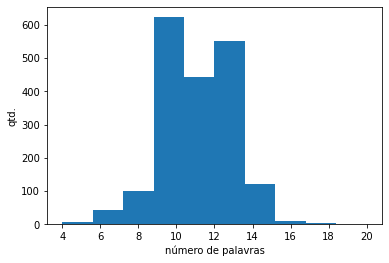

In [18]:
turismo.title_n_words.hist();
plt.xlabel('número de palavras')
plt.ylabel('qtd.')
plt.grid(b=None)
plt.show()

In [19]:
turismo.title_n_words.describe()

count    1903.000000
mean       10.923805
std         1.812440
min         4.000000
25%        10.000000
50%        11.000000
75%        12.000000
max        20.000000
Name: title_n_words, dtype: float64

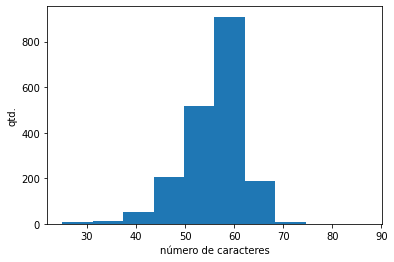

In [20]:
turismo.title_n_chars.hist();
plt.xlabel('número de caracteres')
plt.ylabel('qtd.')
plt.grid(b=None)
plt.show()

In [21]:
turismo.title_n_chars.describe()

count    1903.000000
mean       55.666842
std         6.309523
min        25.000000
25%        52.000000
50%        57.000000
75%        60.000000
max        87.000000
Name: title_n_chars, dtype: float64

3. Limpando os dados, extraindo os tokens 

In [22]:
STOP_WORDS

{'a',
 'acerca',
 'ademais',
 'adeus',
 'agora',
 'ainda',
 'algo',
 'algumas',
 'alguns',
 'ali',
 'além',
 'ambas',
 'ambos',
 'antes',
 'ao',
 'aos',
 'apenas',
 'apoia',
 'apoio',
 'apontar',
 'após',
 'aquela',
 'aquelas',
 'aquele',
 'aqueles',
 'aqui',
 'aquilo',
 'as',
 'assim',
 'através',
 'atrás',
 'até',
 'aí',
 'baixo',
 'bastante',
 'bem',
 'boa',
 'bom',
 'breve',
 'cada',
 'caminho',
 'catorze',
 'cedo',
 'cento',
 'certamente',
 'certeza',
 'cima',
 'cinco',
 'coisa',
 'com',
 'como',
 'comprida',
 'comprido',
 'conhecida',
 'conhecido',
 'conselho',
 'contra',
 'contudo',
 'corrente',
 'cuja',
 'cujo',
 'custa',
 'cá',
 'da',
 'daquela',
 'daquele',
 'dar',
 'das',
 'de',
 'debaixo',
 'demais',
 'dentro',
 'depois',
 'des',
 'desde',
 'dessa',
 'desse',
 'desta',
 'deste',
 'deve',
 'devem',
 'deverá',
 'dez',
 'dezanove',
 'dezasseis',
 'dezassete',
 'dezoito',
 'diante',
 'direita',
 'disso',
 'diz',
 'dizem',
 'dizer',
 'do',
 'dois',
 'dos',
 'doze',
 'duas',
 'dá

In [23]:
STOP_WORDS.add('ao')

In [24]:
# Obtendo um título na base de notícias
rev = turismo.iloc[0]['title']
rev

'Latam inaugura voo direto de 15 horas entre Chile e Austrália'

In [25]:
#### Limpando os dados

rev = limpa_texto(rev)

In [26]:
rev

'latam inaugura voo direto de 15 horas entre chile e austrália'

Observe que o texto agora está minúsculo e foram removidos caracteres não-numericos.

In [27]:
### veja outro exemplo
rev2 = turismo.iloc[5]['title']

In [60]:
limpa_texto(turismo.iloc[5]['title'])

'viagem ao japão é aula de cultura e tradição diz ator jayme matarazzo'

Verificando os tokens e o parsing

In [29]:
rev = nlp_pt(rev) #### Aqui acontece toda a mágica do Spacy

def exibe_tokens(texto):
    col_names = ['ALPHA', 'PUNCT', 'LIKE_NUM', 'POS']
    formatted_text = '{:>16}' * (len(col_names) + 1)
    print('\n', formatted_text.format('INPUT WORD', *col_names), '\n','='*130)

    for token in texto:
        output = [token.text, token.is_alpha, token.is_punct, token.like_num, token.pos_]
        print(formatted_text.format(*output))


exibe_tokens(rev)


       INPUT WORD           ALPHA           PUNCT        LIKE_NUM             POS 
           latam               1               0               0            VERB
        inaugura               1               0               0            VERB
             voo               1               0               0            NOUN
          direto               1               0               0             ADJ
              de               1               0               0             ADP
              15               0               0               1             NUM
           horas               1               0               0            NOUN
           entre               1               0               0             ADP
           chile               1               0               0           PROPN
               e               1               0               0           CCONJ
       austrália               1               0               0            VERB


In [30]:
from spacy import displacy
displacy.render(rev, style='dep', jupyter=True)

In [31]:
rev2 = limpa_texto(turismo.iloc[5]['title'])

In [32]:
rev2 = nlp_pt(rev2)
exibe_tokens(rev2)


       INPUT WORD           ALPHA           PUNCT        LIKE_NUM             POS 
          viagem               1               0               0            NOUN
              ao               1               0               0             ADP
           japão               1               0               0           PROPN
               é               1               0               0             AUX
            aula               1               0               0            NOUN
              de               1               0               0             ADP
         cultura               1               0               0            NOUN
               e               1               0               0           CCONJ
        tradição               1               0               0            NOUN
             diz               1               0               0            VERB
            ator               1               0               0            NOUN
           jayme         

In [33]:
displacy.render(rev2, style="dep", jupyter=True)

Vamos remover as stopwords

In [34]:
turismo['title_clean'] = turismo['title'].apply(lambda x: limpa_texto(x))

In [35]:
turismo.head()

,title,text,date,category,subcategory,link,title_n_words,title_n_chars,title_clean
381,Latam inaugura voo direto de 15 horas entre Ch...,Animem-se os que pretendem cruzar o Pacífico e...,2017-06-10,turismo,NaN,http://www1.folha.uol.com.br/turismo/2017/10/1...,11,51,latam inaugura voo direto de 15 horas entre ch...
414,Turismo de Las Vegas deve se recuperar em mese...,O massacre em Las Vegas afetará o turismo da c...,2017-06-10,turismo,NaN,http://www1.folha.uol.com.br/turismo/2017/10/1...,11,54,turismo de las vegas deve se recuperar em mese...
522,Brasileiro cria app para economizar no passeio...,"Com cerca de 50 mil visitantes por dia, Veneza...",2017-05-10,turismo,NaN,http://www1.folha.uol.com.br/turismo/2017/10/1...,11,58,brasileiro cria app para economizar no passeio...
602,AirBnB passa a fazer reserva de restaurantes,A plataforma de hospedagem Airbnb anunciou que...,2017-05-10,turismo,NaN,http://www1.folha.uol.com.br/turismo/2017/10/1...,7,38,airbnb passa a fazer reserva de restaurantes
609,Museus lembram quatro décadas de opressão sovi...,Nos países que viveram sob a órbita da União S...,2017-05-10,turismo,NaN,http://www1.folha.uol.com.br/turismo/2017/10/1...,10,62,museus lembram quatro décadas de opressão sovi...


In [36]:
turismo['title_clean_no_stop'] = turismo['title_clean'].apply(lambda x : remove_stop(x))

In [37]:
turismo.head()

,title,text,date,category,subcategory,link,title_n_words,title_n_chars,title_clean,title_clean_no_stop
381,Latam inaugura voo direto de 15 horas entre Ch...,Animem-se os que pretendem cruzar o Pacífico e...,2017-06-10,turismo,NaN,http://www1.folha.uol.com.br/turismo/2017/10/1...,11,51,latam inaugura voo direto de 15 horas entre ch...,latam inaugura voo direto 15 horas chile austr...
414,Turismo de Las Vegas deve se recuperar em mese...,O massacre em Las Vegas afetará o turismo da c...,2017-06-10,turismo,NaN,http://www1.folha.uol.com.br/turismo/2017/10/1...,11,54,turismo de las vegas deve se recuperar em mese...,turismo las vegas recuperar analistas
522,Brasileiro cria app para economizar no passeio...,"Com cerca de 50 mil visitantes por dia, Veneza...",2017-05-10,turismo,NaN,http://www1.folha.uol.com.br/turismo/2017/10/1...,11,58,brasileiro cria app para economizar no passeio...,brasileiro cria app economizar passeio gôndola...
602,AirBnB passa a fazer reserva de restaurantes,A plataforma de hospedagem Airbnb anunciou que...,2017-05-10,turismo,NaN,http://www1.folha.uol.com.br/turismo/2017/10/1...,7,38,airbnb passa a fazer reserva de restaurantes,airbnb passa reserva restaurantes
609,Museus lembram quatro décadas de opressão sovi...,Nos países que viveram sob a órbita da União S...,2017-05-10,turismo,NaN,http://www1.folha.uol.com.br/turismo/2017/10/1...,10,62,museus lembram quatro décadas de opressão sovi...,museus lembram décadas opressão soviética países


In [38]:
turismo.iloc[0]['title_clean']

'latam inaugura voo direto de 15 horas entre chile e austrália'

In [39]:
turismo.iloc[0]['title_clean_no_stop']

'latam inaugura voo direto 15 horas chile austrália'

## **Lematização**

In [40]:
turismo['title_lemmas'] = turismo['title_clean_no_stop'].apply(lambda x: limpa_texto2(x))

In [62]:
turismo.iloc[0]['title_lemmas'] 

'latar inaugurar voo direto 15 hora Chile austráliar'

In [63]:
turismo.iloc[5]['title_lemmas'] 

'viagem Japão aula cultura tradição ator Jayme Matarazzo'

In [41]:
turismo.head()

,title,text,date,category,subcategory,link,title_n_words,title_n_chars,title_clean,title_clean_no_stop,title_lemmas
381,Latam inaugura voo direto de 15 horas entre Ch...,Animem-se os que pretendem cruzar o Pacífico e...,2017-06-10,turismo,NaN,http://www1.folha.uol.com.br/turismo/2017/10/1...,11,51,latam inaugura voo direto de 15 horas entre ch...,latam inaugura voo direto 15 horas chile austr...,latar inaugurar voo direto 15 hora Chile austr...
414,Turismo de Las Vegas deve se recuperar em mese...,O massacre em Las Vegas afetará o turismo da c...,2017-06-10,turismo,NaN,http://www1.folha.uol.com.br/turismo/2017/10/1...,11,54,turismo de las vegas deve se recuperar em mese...,turismo las vegas recuperar analistas,turismo las vega recuperar analista
522,Brasileiro cria app para economizar no passeio...,"Com cerca de 50 mil visitantes por dia, Veneza...",2017-05-10,turismo,NaN,http://www1.folha.uol.com.br/turismo/2017/10/1...,11,58,brasileiro cria app para economizar no passeio...,brasileiro cria app economizar passeio gôndola...,brasileiro criar app economizar passeio gôndol...
602,AirBnB passa a fazer reserva de restaurantes,A plataforma de hospedagem Airbnb anunciou que...,2017-05-10,turismo,NaN,http://www1.folha.uol.com.br/turismo/2017/10/1...,7,38,airbnb passa a fazer reserva de restaurantes,airbnb passa reserva restaurantes,Airbnb passar reserva restaurante
609,Museus lembram quatro décadas de opressão sovi...,Nos países que viveram sob a órbita da União S...,2017-05-10,turismo,NaN,http://www1.folha.uol.com.br/turismo/2017/10/1...,10,62,museus lembram quatro décadas de opressão sovi...,museus lembram décadas opressão soviética países,museu lembrar década opressão soviético país


In [42]:
turismo.iloc[5]

title                  'Viagem ao Japão é aula de cultura e tradição'...
text                   O ator Jayme Matarazzo, 31, aproveita os inter...
date                                                          2017-05-10
category                                                         turismo
subcategory                                                          NaN
link                   http://www1.folha.uol.com.br/turismo/2017/10/1...
title_n_words                                                         13
title_n_chars                                                         60
title_clean            viagem ao japão é aula de cultura e tradição d...
title_clean_no_stop    viagem japão aula cultura tradição ator jayme ...
title_lemmas           viagem Japão aula cultura tradição ator Jayme ...
Name: 615, dtype: object

In [43]:
turismo.iloc[5]['title_clean']

'viagem ao japão é aula de cultura e tradição diz ator jayme matarazzo'

In [44]:
turismo.iloc[5]['title_clean_no_stop']

'viagem japão aula cultura tradição ator jayme matarazzo'

In [45]:
turismo.iloc[5]['title_lemmas']

'viagem Japão aula cultura tradição ator Jayme Matarazzo'

N-grams

In [46]:
titulos = " ".join(turismo['title_lemmas'])

In [47]:
token = word_tokenize(titulos)
bigrams = ngrams(token,2)
trigrams = ngrams(token,3)
fourgrams = ngrams(token,4)
fivegrams = ngrams(token,5)

In [48]:
print(Counter(bigrams).most_common(10))

[(('fotógrafo', 'registrar'), 31), (('álbum', 'viagem'), 22), (('atrair', 'turista'), 19), (('companhia', 'aéreo'), 18), (('fotógrafo', 'clico'), 14), (('atração', 'turístico'), 10), (('levar', 'turista'), 10), (('estação', 'esqui'), 10), (('opção', 'pacote'), 9), (('fotógrafar', 'registrar'), 8)]


In [49]:
print(Counter(trigrams).most_common(10))

[(('world', 'trade', 'center'), 5), (('fotógrafo', 'registrar', 'paisagem'), 4), (('tema', 'ensaio', 'fotográfico'), 4), (('parque', 'harry', 'potter'), 4), (('inaugurar', 'museu', 'dedicar'), 4), (('mundo', 'fotógrafo', 'registrar'), 3), (('pacote', 'último', 'hora'), 3), (('último', 'hora', 'viajar'), 3), (('estação', 'esqui', 'EUA'), 3), (('país', 'álbum', 'viagem'), 3)]


In [50]:
print(Counter(fourgrams).most_common(10))

[(('pacote', 'último', 'hora', 'viajar'), 3), (('contar', 'lugar', 'preferir', 'Brasil'), 2), (('disney', 'Hong', 'Kong', 'ter'), 2), (('vasculhar', 'rede', 'social', 'emitir'), 2), (('rede', 'social', 'emitir', 'visto'), 2), (('montanha', 'russo', 'alto', 'rápido'), 2), (('primavera', 'árabe', 'guerra', 'sírio'), 2), (('árabe', 'guerra', 'sírio', 'gerar'), 2), (('guerra', 'sírio', 'gerar', 'crise'), 2), (('sírio', 'gerar', 'crise', 'turismo'), 2)]


Tópicos

In [51]:
vectorizer = CountVectorizer(min_df=10, max_df=0.9, stop_words=STOP_WORDS, lowercase=True)

In [52]:
data_vectorized = vectorizer.fit_transform(turismo['title_lemmas'])

In [53]:
data_vectorized

<1903x216 sparse matrix of type '<class 'numpy.int64'>'
	with 5075 stored elements in Compressed Sparse Row format>

In [54]:
NUM_TOPICS = 2

In [55]:
lda = LatentDirichletAllocation(n_components=NUM_TOPICS, max_iter=30, learning_method='online',verbose=True)
data_lda = lda.fit_transform(data_vectorized)

iteration: 1 of max_iter: 30
iteration: 2 of max_iter: 30
iteration: 3 of max_iter: 30
iteration: 4 of max_iter: 30
iteration: 5 of max_iter: 30
iteration: 6 of max_iter: 30
iteration: 7 of max_iter: 30
iteration: 8 of max_iter: 30
iteration: 9 of max_iter: 30
iteration: 10 of max_iter: 30
iteration: 11 of max_iter: 30
iteration: 12 of max_iter: 30
iteration: 13 of max_iter: 30
iteration: 14 of max_iter: 30
iteration: 15 of max_iter: 30
iteration: 16 of max_iter: 30
iteration: 17 of max_iter: 30
iteration: 18 of max_iter: 30
iteration: 19 of max_iter: 30
iteration: 20 of max_iter: 30
iteration: 21 of max_iter: 30
iteration: 22 of max_iter: 30
iteration: 23 of max_iter: 30
iteration: 24 of max_iter: 30
iteration: 25 of max_iter: 30
iteration: 26 of max_iter: 30
iteration: 27 of max_iter: 30
iteration: 28 of max_iter: 30
iteration: 29 of max_iter: 30
iteration: 30 of max_iter: 30


In [56]:
def selected_topics(model, vectorizer, top_n=10):
    for idx, topic in enumerate(model.components_):
        print("Topic %d:" % (idx))
        print([(vectorizer.get_feature_names()[i], topic[i])
                        for i in topic.argsort()[:-top_n - 1:-1]]) 

In [57]:
print("LDA Model:")
selected_topics(lda, vectorizer)

LDA Model:
Topic 0:
[('hotel', 109.01173798345762), ('brasil', 80.23240119377508), ('conhecer', 77.00040278407079), ('ano', 75.7305085520432), ('mundo', 73.70036131237049), ('museu', 71.45852556732146), ('parque', 66.8073704172965), ('eua', 62.54223460697508), ('rio', 60.96068259564591), ('atração', 58.0032109032166)]
Topic 1:
[('turista', 196.56252054026396), ('viagem', 118.99801066412547), ('turismo', 99.15583660344386), ('fotógrafo', 86.21188399154902), ('cidade', 80.52935600278252), ('brasileiro', 56.72745124298476), ('país', 56.33222230916783), ('destino', 54.86435156555634), ('registrar', 54.03456686127778), ('pacote', 47.34967498748177)]


In [58]:
import pyLDAvis.sklearn

pyLDAvis.enable_notebook()
dash = pyLDAvis.sklearn.prepare(lda, data_vectorized, vectorizer, mds='tsne')
dash

ModuleNotFoundError: ignored